## Комаров Петр  |  лаба №4
#### `github.com/petr0leum`
### _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _
### <i>Дисклеймер: не уверен, что правильно</i>
### _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _

Импортируем `numpy` для работы с векторами и `matplotlib` для графиков:

In [1]:
import numpy as np
import matplotlib.pyplot as plt

В условии дана функция и узлы этой функции на интервале $[0;\pi]$: <br><br> $$source\ fn = \sin{X} * \sqrt{X} + 1,\ \ \forall X \subset I\!R$$

In [3]:
source_fn = lambda xset: np.sin(xset) * np.sqrt(xset) + 1
custom_nodes = [(item * np.pi/7) for item in [0, 0.5, 1.5, 2.5, 4.5, 6.5, 7]]

Сформируем объекты для дальнейшего решения:

In [4]:
domain = np.linspace(0, np.pi, 1000)   # эмуляция интервала [0; π]

Наклон сплайна в $i$ узле –— производная интерполируемой функции в этом узле. Для самой первой и последней нод (начало и конец интервала $[0; \pi]$ соответственно) производные считаются по другой формуле, чем для всех остальных нод: будем это учитывать. 

In [5]:
def slope(i, fn_range, h):
    if i == 0:
        return (4*fn_range[1] - fn_range[2] - 3*fn_range[0]) / (2*h)

    elif i == len(fn_range)-1:
        return (3*fn_range[-1] - fn_range[-1-2] - 3*fn_range[-1-1]) / (2*h)
    
    else:
        return (fn_range[i+1] + fn_range[i-1]) / (2*h)

Напишем функцию <b>spline</b> для кубического сплайна.
Будем обрабатывать как и стандартный "общий" случай, когда N узлов идут через равный шаг, так и позволять передавать кастомные ноды (см. условие, там ноды с рандомным шагом расставлены). Также не будем хранить в памяти все полиномы для всех отрезков, а будем йелдить их для каждого отрезка (<a href="https://habr.com/post/50026/">`про yield читай тут`</a>):

In [6]:
def spline(X, source_fn, a, b, **kwargs):
    """
    Args:
        X:                Неизвестная переменная. int/float/list/np.array
        source_fn:        Интерполируемая нами исходная функция
        a, b (float):     Границы интервала, на котором интерполируем
        **kwargs (dict):  Именованные аргументы. Ловим там nodes и N
    """
    # Считываем кастомные ноды или формируем свои:
    if 'nodes' in kwargs:
        nodes = kwargs['nodes']
        N = len(nodes)
        h = [nodes[ind+1] - node  for ind,node in enumerate(nodes[:-1])]
    else:
        assert 'N' in kwargs, 'Error: write parameter N or use custom nodes'
        N = kwargs['N']
        h = [(b - a) / N for _ in range(N)]
        nodes = np.linspace(a, b, N+1)

    # Добавляем nodes в X, чтобы потом возвращать эти точки вместе с X (как границы интервалов)    
    X = np.append(X, nodes)
    X.sort()
    X_aslist = X.tolist()
        
    # Йелдим сплайн-полиномы для каждого отрезка между нодами:
    for ind,node in enumerate(nodes[:-1]):
        nnode = nodes[ind+1] # next node
        
        # Формируем подмножества нашего линейного пространства X: [Xi; Xi+1]
        loc_start = X_aslist.index(node)
        loc_end = X_aslist.index(nnode)
        Xrange = X_aslist[loc_start:loc_end]
        Xrange = np.array(Xrange)
        
        # Формула сплайна, большая и страшная:
        
        st1 = source_fn(node) * np.power(nnode-Xrange, 2) * 2 * (Xrange - node + 0.5*h[ind]) / h[ind]**3
        st2 = source_fn(nnode) * np.power(Xrange-node, 2) * 2 * (nnode - Xrange + 0.5*h[ind]) / h[ind]**3        
        st3 = slope(ind, source_fn(nodes), h[ind]) * np.power(nnode-Xrange, 2) * (Xrange - node) / h[ind]**2
        st4 = slope(ind+1, source_fn(nodes), h[ind]) * np.power(Xrange-node, 2) * (Xrange - nnode) / h[ind]**2
        
        yield (st1 + st2 + st3 + st4, Xrange)

Построим сплайны для общего случая. Пусть функция задана на интервале $[0; \pi]$; будем интерполировать функцию на 7 точках:

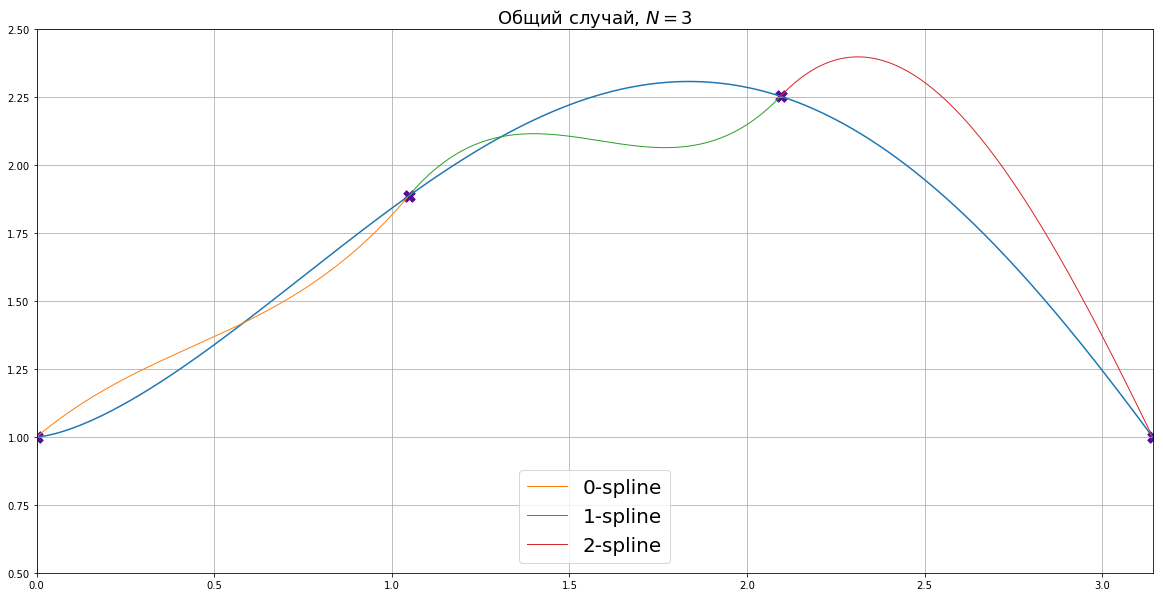

In [7]:
N = 3

# Для дизайна графика:
fig, ax = plt.subplots(figsize=(20, 10))
ax.set_ylim(0.5, 2.5)
ax.set_xlim(0, np.pi)
# ax.plot(domain, source_fn(domain), linewidth=2, c='black')

plt.plot(domain, source_fn(domain))

# Итерируемся по нашему итератору spline и строим полиномы:
for i,poly in enumerate(spline(domain, source_fn, 0, np.pi, N=N)):
    ax.plot(poly[1], poly[0], linewidth=1, label=f'{i}-spline')
   
plt.title(f'Общий случай, $N={N}$', fontsize=18)
ax.grid(True, which='both')
ax.legend(loc=8, prop={'size': 20})

# для построения нод сформируем массив с ними:
nodes = np.linspace(0, np.pi, N+1)
# и построим ещё и ноды:
for i in nodes:
    ax.scatter(i, source_fn(i), marker='X', s=130, color='#590B92')

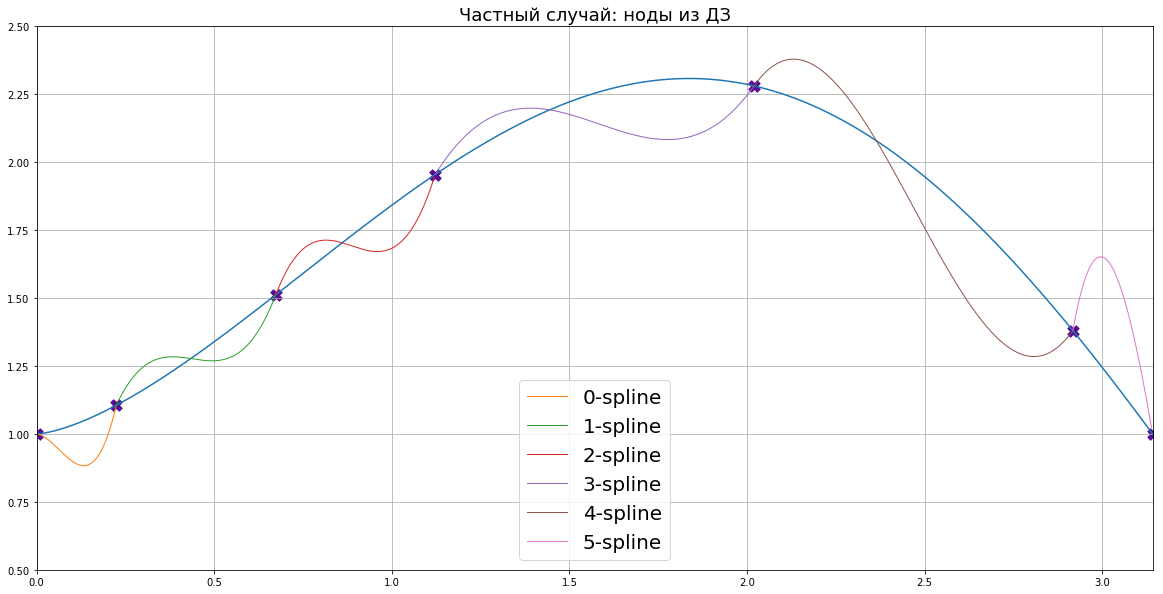

In [8]:
# Для дизайна графика:
fig, ax = plt.subplots(figsize=(20, 10))
ax.set_ylim(0.5, 2.5)
ax.set_xlim(0, np.pi)
# ax.plot(domain, source_fn(domain), linewidth=2, c='black')

plt.plot(domain, source_fn(domain))

# Итерируемся по нашему итератору spline и строим полиномы:
for i,poly in enumerate(spline(domain, source_fn, 0, np.pi, nodes=custom_nodes)):
    ax.plot(poly[1], poly[0], linewidth=1, label=f'{i}-spline')
   
plt.title('Частный случай: ноды из ДЗ', fontsize=18)
ax.grid(True, which='both')
ax.legend(loc=8, prop={'size': 20})

for i in custom_nodes:
    ax.scatter(i, source_fn(i), marker='X', s=130, color='#590B92')